In [1]:
pip install warmup_scheduler_pytorch


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import time
import numpy as np
import pandas as pd
# image manipulation
import cv2
import PIL
from PIL import Image

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# helpers
from tqdm.notebook import tqdm
import time
import copy
import gc
from enum import Enum


# for cnn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split, TensorDataset, Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, ExponentialLR, CosineAnnealingLR
from torchvision import models
from torchmetrics.classification import BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryAccuracy, BinaryROC, BinaryAUROC, BinaryPrecisionRecallCurve
from torchvision import transforms
from warmup_scheduler_pytorch import WarmUpScheduler


# Summary:
* Upsampling 1 positive:5 negatives
* Positive weghtin in loss function 5
* 512x512 images
* 8 epochs
* Batch size 32
* Validation set size = 10%

In [3]:
torch.manual_seed(0)

In [4]:
csvpathtrain = '/kaggle/input/rsna-breast-cancer-detection/train.csv'

dftrain = pd.read_csv(csvpathtrain)
dftrain.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


Text(0.5, 0.98, 'Cancer distribution')

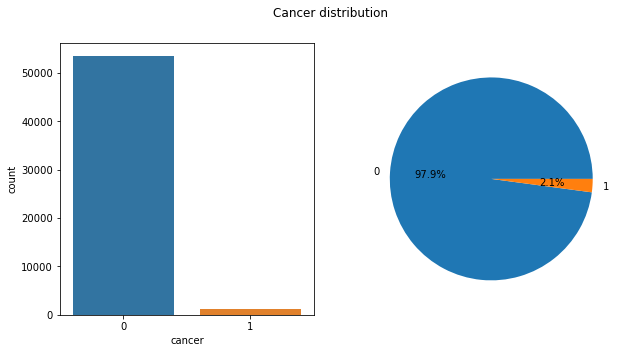

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
########## PLOTING CANCER ################
splot = sns.countplot(ax = axes[0], x = dftrain['cancer'])

s = dftrain['cancer'].value_counts()
axes[1].pie(s, autopct="%.1f%%", labels = s.keys())
fig.suptitle('Cancer distribution')

In [6]:
total_samples = len(dftrain['cancer'])
positive_samples = sum(dftrain['cancer'] == 1)
negative_samples = total_samples - positive_samples
print(f"{total_samples}, {positive_samples}, {negative_samples}")

54706, 1158, 53548


In [7]:
samples_weight = torch.Tensor([positive_samples / total_samples, negative_samples / total_samples]).type(dtype = torch.float32)

samples_weight

tensor([0.0212, 0.9788])

In [8]:
class RSNAMamographyDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.df = pd.read_csv(annotations_file)
        # MODIFICATION. Drop all difficult negative casses
        self.df = self.df.drop(self.df[self.df['difficult_negative_case'] == 1].index)
        print(len(self.df))
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    


    def __getitem__(self, ind):
        
        img_path = f"{self.img_dir}/{self.df.iloc[ind].patient_id}_{self.df.iloc[ind].image_id}.png"
        img = Image.open(img_path).convert('RGB')
        
        label = self.df.iloc[ind].cancer
        # there is no need to normalize data, it has already been normalized
        if self.transform:
            img = self.transform(img).to(torch.float32) 
        else:
            default_transform = transforms.Compose([transforms.ToTensor()])
            img = default_transform(img).to(torch.float32)
            
        #sample = {"image" : img, "label": label}
        return img, label

In [9]:
train_csv = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
imgs_dir = '/kaggle/input/rsnamamorgaphybreastcancerrecognition512x512'

augmentator = transforms.Compose([
    # input for augmentator is always PIL image
    # transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(5),
    transforms.ToTensor(), # return it as a tensor and transforms it to [0, 1]
])
dataset = RSNAMamographyDataset(train_csv, imgs_dir, augmentator)

47001


In [10]:
# Use torch.utils.data to create a DataLoader 
# that will take care of creating batches 

# TODO, remove using half of dataset
#dataset, _ = random_split(dataset, [int(len(dataset)*0.02), int(len(dataset)*0.98 + 1)])
# split training into validation and train
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])



In [11]:

print("Class counting...")
labels = dftrain['cancer'].values
class_sample_count = np.array([len(np.where(labels == l)[0]) for l in np.unique(labels)])


# the trouble with this aproach is that it now has to load all images one by one and label them
# but it saves RAM memory in training process
#class_sample_count = np.zeros(2)

#print("Class counting...")
#for _, label in tqdm(train_dataset):
#    class_sample_count[label] += 1

print(class_sample_count)

# This maybe apply, maybe not
# since there is big class imbalance, we will not sample positive class THAT frequent
# to be closer to 'reality, every fifth image will be cancer (instead of 50/50 distribution)'
class_sample_count[1] *= 5
class_weights = 1. / class_sample_count

print("Adding weights to each training sample...")
sample_weights = [class_weights[label] for _, label in tqdm(train_dataset)]


Class counting...
[53548  1158]
Adding weights to each training sample...


  0%|          | 0/42301 [00:00<?, ?it/s]

In [12]:
sample_weights = np.array(sample_weights)
sample_weights = torch.from_numpy(sample_weights)

In [13]:
weighted_random_sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

In [14]:

batch_size = 32

# Applying random sampler just tu train dataset, not for validation, since the validation dataset should be imitation of 'real' DS
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers = 2, pin_memory = True, sampler = weighted_random_sampler)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle = True, pin_memory = True)


In [15]:
dataloaders = {'train' : train_dataloader, 'val' : val_dataloader}
dataset_sizes = {'train': train_size, 'val' : val_size}

In [16]:
print(len(train_dataset), len(val_dataset))
print(len(train_dataloader), len(val_dataloader))

42301 4700
1322 147


There are 29.0 negative and 3.0 positive samples in this batch.


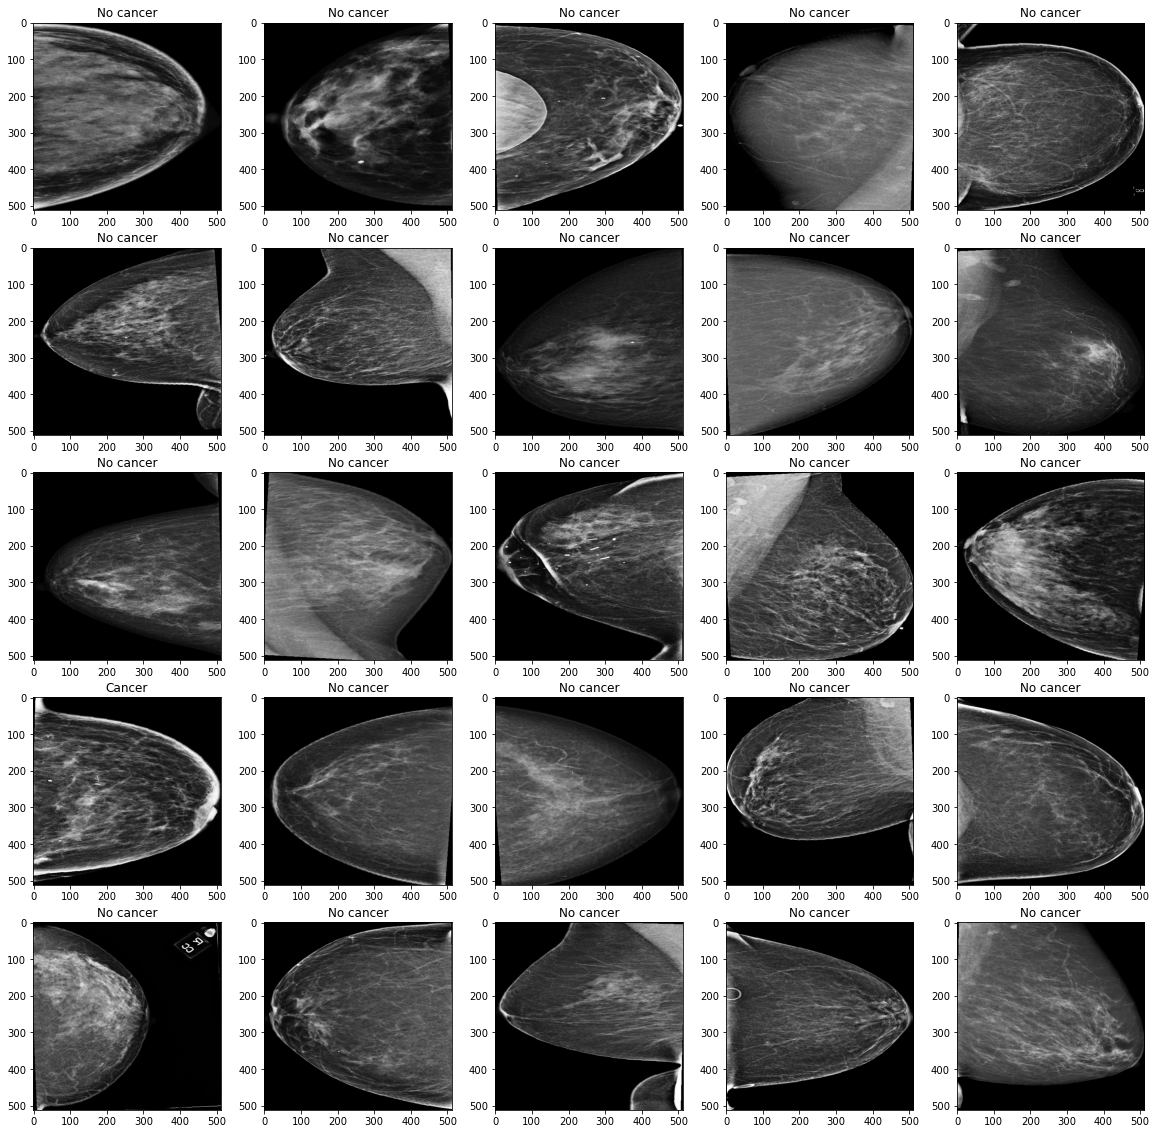

In [17]:
rows = 5
cols = 5
plt.subplots(rows, cols, figsize = (20, 20))

batch_imgs, batch_labels = next(iter(train_dataloader))
i = 0
for img in batch_imgs:
    if i >= rows*cols:
        break
    plt.subplot(rows, cols, i + 1)
    plt.title("Cancer" if batch_labels[i] == 1 else "No cancer")
    plt.imshow(img.permute(1, 2, 0))

    i += 1

labels_count = np.zeros(2)
for l in batch_labels:
    labels_count[l] += 1 
    
print(f'There are {labels_count[0]} negative and {labels_count[1]} positive samples in this batch.')

In [18]:
img.size()

torch.Size([3, 512, 512])

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Current device is {device}')

Current device is cuda


Resnext model  accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=232 using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=224. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
<br>
Question: does it mean that it can't be used for high resolutions?

In [20]:

class CNN(nn.Module):
    def __init__(self, n = 5):
        super(CNN, self).__init__()
        self.network = models.resnext50_32x4d(pretrained = True)
        
        
        # freeze first n layers
        ct = 0
        if n:
            print('FREEZED LAYERS:')
        for child in self.network.children():
            ct += 1
            if ct <= n:
                print('*'*100)
                print(child)

                for param in child.parameters():
                    param.requires_grad = False

        n_features = self.network.fc.out_features
        # add additional layer that maps 2048 extracted features from resnet to 1 feature determining the class
        self.classifier_layer = nn.Sequential(
            nn.Linear(n_features , 64),
            nn.Dropout(0.3),
            nn.Linear(64 , 1)
        )
    
    def forward(self, xb):        
        xb = self.network(xb)
        xb = self.classifier_layer(xb)
        return torch.sigmoid(xb)

In [21]:
# create class for earlystopping
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_loss = np.inf

    def early_stop(self, loss):
        if loss <= self.min_loss:
            self.min_loss = loss
            self.counter = 0
        elif loss > (self.min_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [22]:
def BCELoss_class_weighted(weights):
    """
    weights[0] is weight for class 0 (negative class)
    weights[1] is weight for class 1 (positive class)
    """
    def loss(y_pred, target):
        y_pred = torch.clamp(y_pred,min=1e-7,max=1-1e-7) # for numerical stability
        bce = - weights[1] * target * torch.log(y_pred) - (1 - target) * weights[0] * torch.log(1 - y_pred)
        return torch.mean(bce)

    return loss

In [23]:
# defining the model
model = CNN()
model.to(device)


# Try this initial LR
init_lr = 4e-05
# defining the optimizer
optimizer = Adam(model.parameters(), lr=init_lr)
# defining learning rate schedualer to fight plateues
# TODO: figure out how to measure validation loss independently
# scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
# defining the loss function
# Binary cross entropy is chosen because it is the classification problem
#labels = dftrain['cancer'].values
# the weight should be smaller if class count is higher
#neg_count = sum(labels == 0)
#pos_count = sum(labels == 1)
w_pos = 5
w_neg = 1
print(f"Class weight for negative class: {w_neg}, and for positive {w_pos}")
criterion = BCELoss_class_weighted(weights = [w_neg, w_pos])
#criterion = nn.BCEWithLogitsLoss()
# define early stopping
earlystoper = EarlyStopper(patience = 3)


checkpoint = {'model': CNN(),
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict(),
             'threshold' : 0.5,
             'batch_size': batch_size}

#path_to_weights = '/kaggle/input/resnext50-upsample-5epochs/checkpoint.pth'

#checkpoint = torch.load(path_to_weights)
#model, best_weights = checkpoint['model'], checkpoint['state_dict']
#model.load_state_dict(best_weights)
#model.to(device)


# print(model)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

FREEZED LAYERS:
****************************************************************************************************
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
****************************************************************************************************
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
****************************************************************************************************
ReLU(inplace=True)
****************************************************************************************************
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
****************************************************************************************************
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128,

In [24]:
n_epochs = 8

In [25]:
#lr_scheduler = ExponentialLR(optimizer, gamma = 0.85, last_epoch=- 1, verbose=False)
lr_scheduler = CosineAnnealingLR(optimizer, n_epochs, last_epoch = -1)
# define lr scheduler
warmup_scheduler = WarmUpScheduler(optimizer, lr_scheduler,
                                   warmup_steps=1,
                                   warmup_start_lr=init_lr/10,
                                   warmup_mode='linear')

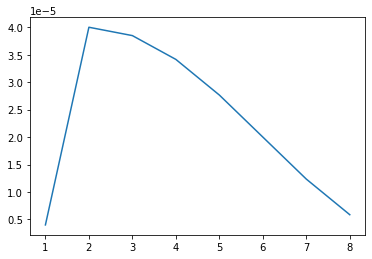

In [26]:
scheduled_lr = []

for i in range(n_epochs):
    lr = optimizer.param_groups[0]['lr']
    scheduled_lr.append(lr)
    warmup_scheduler.step()
    
plt.plot(range(1, n_epochs + 1), scheduled_lr)


In [27]:
def find_optim_thres(fpr, tpr, thresholds):
    optim_thres = thresholds[0]
    inx = 0
    min_dist = 1.0
    for i in range(len(fpr)):
        dist = np.linalg.norm(np.array([0.0, 1.0]) - np.array([fpr[i], tpr[i]]))
        if dist < min_dist:
            min_dist = dist
            optim_thres = thresholds[i]
            inx = i
            
    return optim_thres, inx
        

After plotting, LR schedualer needs initialization.

In [28]:
#lr_scheduler = ExponentialLR(optimizer, gamma = 0.85, last_epoch=- 1, verbose=False)
lr_scheduler = CosineAnnealingLR(optimizer, n_epochs, last_epoch = -1)
# define lr scheduler
warmup_scheduler = WarmUpScheduler(optimizer, lr_scheduler,
                                   warmup_steps=1,
                                   warmup_start_lr=init_lr/10,
                                   warmup_mode='linear')

In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    metricf1 = BinaryF1Score()
    precision = BinaryPrecision()
    recall = BinaryRecall()
    accuracy = BinaryAccuracy()
    roc = BinaryROC()
    auc = BinaryAUROC()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = -1.0
    
    train_metrics = {'loss' : [], 'acc' : [], 'f1': [], 'precision': [], 'recall': [], 'auc': [], 'lr': []}
    val_metrics = {'loss' : [], 'acc' : [], 'f1': [], 'precision': [], 'recall': [], 'auc': []}
    
    
    # inital threshold for first epoch, it will change afterwards
    threshold = 0.5
    
    print('Starting training...')
    print('-' * 20)
    for epoch in range(num_epochs):
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            # empty 'all' tensors for saving
            # for calculating aoc at the end of epoch, and for calculating new threshold
            all_outputs = torch.Tensor([])
            all_labels = torch.Tensor([])
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            n_samples = 0
            
            n_correct = 0
            running_f1 = 0.0
            # Iterate over data.
            print(f'{phase} for epoch {epoch + 1}')
            for inputs, labels in tqdm(dataloaders[phase]):
                
                labels = torch.unsqueeze(labels.to(torch.float32), 1)
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = (outputs > threshold).double()
                    #print(all_outputs)
                    #print(outputs)
                    # concatenating all outputs and labels for calculation aoc and new threshold
                    all_outputs = torch.cat((all_outputs, outputs.to('cpu')))
                    all_labels = torch.cat((all_labels, labels.to('cpu')))
                    
                    #print(labels)
                    # _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                # n_samples += labels.size(0)
                running_loss += loss.item()
                # n_correct += (preds == labels).sum().item()
                # running_f1 += metric(outputs, labels) 


                # collect any unused memmory
                gc.collect()
                torch.cuda.empty_cache()
            
            # statistics
            epoch_loss = running_loss / len(dataloaders[phase])
            
            # find true positive and false positive rates for ROC curve
            fpr, tpr, thresholds = roc(all_outputs, all_labels)
            epoch_auc = auc(all_outputs, all_labels)
            # find new threshold
            if phase == 'train':
                # just for train phase calculate threshold
                threshold, _ = find_optim_thres(fpr, tpr, thresholds)
                print(f'New threshold is {threshold}')
            # calculate metrics using new optimized threshold
            epoch_f1 = metricf1(all_outputs > threshold, all_labels)
            epoch_acc = accuracy(all_outputs > threshold, all_labels)
            epoch_precision = precision(all_outputs > threshold, all_labels)
            epoch_recall = recall(all_outputs > threshold, all_labels)
            
            # save all of the statistics for latter analysis
            if phase == 'train':
                train_metrics['lr'].append(optimizer.param_groups[0]['lr'])
                scheduler.step()
                train_metrics['loss'].append(epoch_loss)
                train_metrics['acc'].append(epoch_acc)
                train_metrics['f1'].append(epoch_f1)
                train_metrics['precision'].append(epoch_precision)
                train_metrics['recall'].append(epoch_recall)
                train_metrics['auc'].append(epoch_auc)


            else:
                val_metrics['loss'].append(epoch_loss)
                val_metrics['acc'].append(epoch_acc)
                val_metrics['f1'].append(epoch_f1)
                val_metrics['precision'].append(epoch_precision)
                val_metrics['recall'].append(epoch_recall)
                val_metrics['auc'].append(epoch_auc)



            # deep copy the model
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
                # calclulate new threshold and save model
                checkpoint['threshold'] = threshold
                torch.save(checkpoint, 'checkpoint.pth')

                
        # cant be formated in string
        tr_loss, tr_acc, tr_f1, tr_prec, tr_rec, tr_auc = train_metrics['loss'][-1], train_metrics['acc'][-1],  train_metrics['f1'][-1], train_metrics['precision'][-1], train_metrics['recall'][-1], train_metrics['auc'][-1]
        val_loss, val_acc, val_f1, val_prec, val_rec, val_auc = val_metrics['loss'][-1], val_metrics['acc'][-1], val_metrics['f1'][-1], val_metrics['precision'][-1], val_metrics['recall'][-1], val_metrics['auc'][-1]
        lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch + 1}/{num_epochs}, learning rate: {lr}')
        print(f'Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f}, Train f1: {tr_f1:.4f}, Train Precision: {tr_prec:.4f}, Train Recall: {tr_rec:.4f}, Train AUC: {tr_auc:.4f}')
        print(f'Valitadion Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}, Vall f1: {val_f1:.4f}, Val Precision: {val_prec:.4f}, Val Recall: {val_rec:.4f}, Val AUC: {val_auc:.4f}')
        
        if earlystoper.early_stop(val_loss):
            break
        
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val f1: {best_f1:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_metrics, val_metrics

In [30]:
model, train_metrics, val_metrics = train_model(model, criterion, optimizer, warmup_scheduler, num_epochs=n_epochs)

Starting training...
--------------------
train for epoch 1


  0%|          | 0/1322 [00:00<?, ?it/s]

New threshold is 0.5289965867996216
val for epoch 1


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 1/8, learning rate: 4e-05
Train Loss: 1.0709, Train Acc: 0.6431, Train f1: 0.4094, Train Precision: 0.2964, Train Recall: 0.6617, Train AUC: 0.7153
Valitadion Loss: 0.6233, Validation Acc: 0.7781, Vall f1: 0.1287, Val Precision: 0.0726, Val Recall: 0.5662, Val AUC: 0.7505
train for epoch 2


  0%|          | 0/1322 [00:00<?, ?it/s]

New threshold is 0.5200216770172119
val for epoch 2


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 2/8, learning rate: 3.8477590650225735e-05
Train Loss: 0.8262, Train Acc: 0.7722, Train f1: 0.5592, Train Precision: 0.4381, Train Recall: 0.7727, Train AUC: 0.8552
Valitadion Loss: 0.5998, Validation Acc: 0.8062, Vall f1: 0.1494, Val Precision: 0.0856, Val Recall: 0.5882, Val AUC: 0.7842
train for epoch 3


  0%|          | 0/1322 [00:00<?, ?it/s]

New threshold is 0.5215747952461243
val for epoch 3


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 3/8, learning rate: 3.414213562373095e-05
Train Loss: 0.4957, Train Acc: 0.8793, Train f1: 0.7374, Train Precision: 0.6296, Train Recall: 0.8895, Train AUC: 0.9515
Valitadion Loss: 0.4900, Validation Acc: 0.8996, Vall f1: 0.1690, Val Precision: 0.1111, Val Recall: 0.3529, Val AUC: 0.7575
train for epoch 4


  0%|          | 0/1322 [00:00<?, ?it/s]

New threshold is 0.563050389289856
val for epoch 4


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 4/8, learning rate: 2.7653668647301797e-05
Train Loss: 0.2889, Train Acc: 0.9369, Train f1: 0.8451, Train Precision: 0.7722, Train Recall: 0.9332, Train AUC: 0.9826
Valitadion Loss: 0.4420, Validation Acc: 0.9500, Vall f1: 0.2540, Val Precision: 0.2235, Val Recall: 0.2941, Val AUC: 0.7961
train for epoch 5


  0%|          | 0/1322 [00:00<?, ?it/s]

New threshold is 0.5499297380447388
val for epoch 5


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 5/8, learning rate: 1.9999999999999998e-05
Train Loss: 0.1708, Train Acc: 0.9630, Train f1: 0.9072, Train Precision: 0.8553, Train Recall: 0.9658, Train AUC: 0.9935
Valitadion Loss: 0.4817, Validation Acc: 0.9353, Vall f1: 0.2585, Val Precision: 0.1934, Val Recall: 0.3897, Val AUC: 0.8422
train for epoch 6


  0%|          | 0/1322 [00:00<?, ?it/s]

New threshold is 0.5235753059387207
val for epoch 6


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 6/8, learning rate: 1.2346331352698204e-05
Train Loss: 0.1039, Train Acc: 0.9773, Train f1: 0.9420, Train Precision: 0.9061, Train Recall: 0.9809, Train AUC: 0.9974
Valitadion Loss: 0.6185, Validation Acc: 0.9477, Vall f1: 0.2679, Val Precision: 0.2250, Val Recall: 0.3309, Val AUC: 0.8222
train for epoch 7


  0%|          | 0/1322 [00:00<?, ?it/s]

New threshold is 0.5063938498497009
val for epoch 7


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 7/8, learning rate: 5.8578643762690505e-06
Train Loss: 0.0631, Train Acc: 0.9865, Train f1: 0.9646, Train Precision: 0.9405, Train Recall: 0.9899, Train AUC: 0.9990
Valitadion Loss: 0.7789, Validation Acc: 0.9666, Vall f1: 0.3084, Val Precision: 0.3846, Val Recall: 0.2574, Val AUC: 0.8106
Training complete in 235m 2s
Best val f1: 0.308370


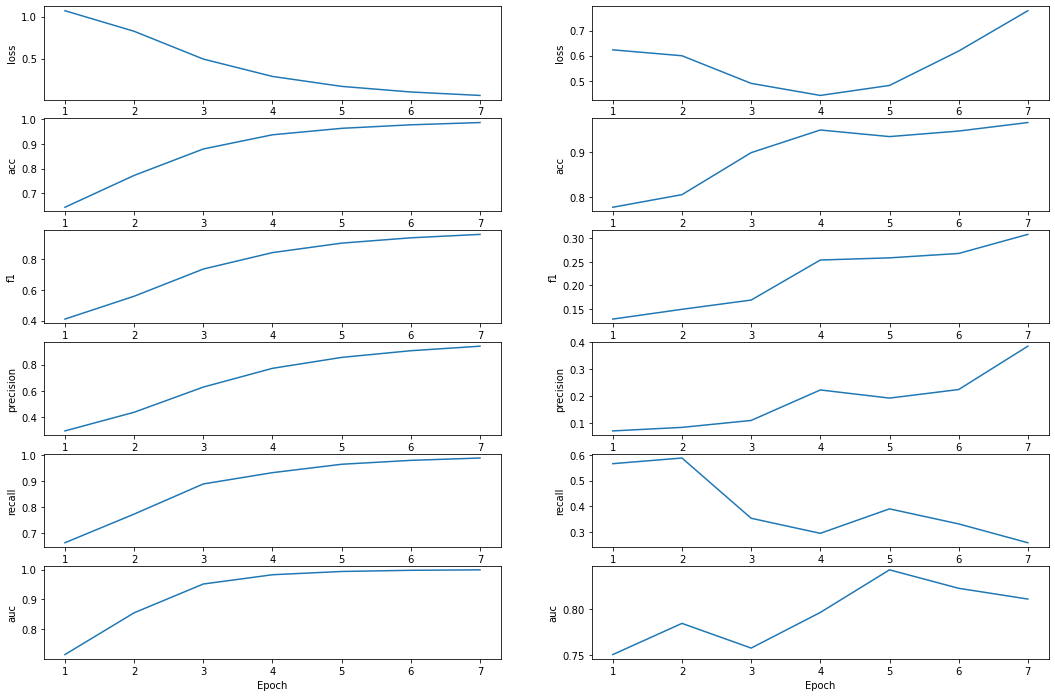

In [31]:
f = plt.subplots(6, 2, figsize = (18, 12))
keys = ['loss', 'acc', 'f1', 'precision', 'recall', 'auc']
i = 0
for key in keys:
    metric = [x for x in train_metrics[key]]
    plt.subplot(6, 2, 2*i + 1)
    plt.plot(range(1, len(metric) + 1), metric)
    plt.xlabel("Epoch")
    plt.ylabel(f"{key}")
    
    
    metric = [x for x in val_metrics[key]]
    plt.subplot(6, 2, 2*i + 2)
    plt.plot(range(1, len(metric) + 1), metric)
    plt.xlabel("Epoch")
    plt.ylabel(f"{key}")
    i += 1
    
plt.show()

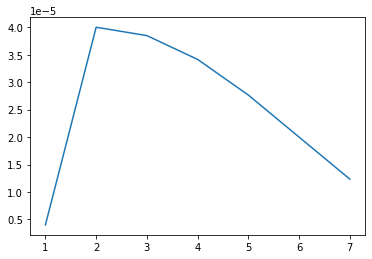

In [32]:
lr = train_metrics['lr']
plt.plot((range(1, len(lr) + 1)), lr)

# Make inference on validation dataset

In [33]:
path_to_weights = '/kaggle/working/checkpoint.pth'

checkpoint = torch.load(path_to_weights)
model, best_weights, optimizer, threshold = checkpoint['model'], checkpoint['state_dict'], checkpoint['optimizer'], checkpoint['threshold']
model.load_state_dict(best_weights)
model.to(device)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    false_positives = []
    false_negatives = []
    y_pred, y_true, y_out = [], [], []
    all_outputs = torch.Tensor([])
    all_labels = torch.Tensor([])
    
    for images, labels in tqdm(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            predicted = outputs > threshold
            n_samples += labels.size(0)
            n_correct += (torch.squeeze(predicted) == labels).sum().item()
            y_pred.append(np.array(torch.squeeze(predicted.cpu()), dtype = 'int32'))
            y_true.append(np.array(torch.squeeze(labels.cpu()), dtype = 'int32'))
            y_out.append(np.array(torch.squeeze(outputs.cpu()), dtype = 'float32'))
            # concatenating all outputs and labels for calculation aoc and new threshold
            all_outputs = torch.cat((all_outputs, outputs.to('cpu')))
            all_labels = torch.cat((all_labels, labels.to('cpu')))
            #if predicted != labels[i]:
            #    if predicted == 1:
            #        false_positives.append(images)
            #    else:
            #        false_negatives.append(images)
            
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} test images: {acc} %')

    y_true = np.concatenate(y_true, axis = 0)
    y_pred = np.concatenate(y_pred, axis = 0)

  0%|          | 0/147 [00:00<?, ?it/s]

Accuracy of the network on the 4700 test images: 93.1063829787234 %


## Confusion matrix

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

<AxesSubplot:>

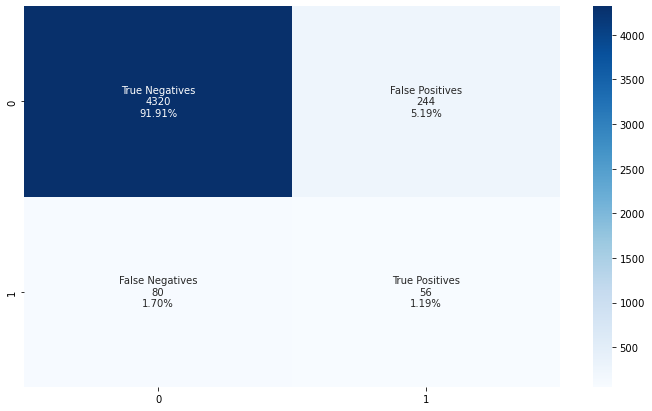

In [35]:
cm = confusion_matrix(np.squeeze(np.array(y_true, dtype = 'int32')), np.squeeze(np.array(y_pred, dtype = 'int32')))
group_names = ['True Negatives','False Positives', 'False Negatives','True Positives']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')



(array([[29.,  1.,  0., ...,  0.,  0.,  0.],
        [27.,  3.,  1., ...,  0.,  0.,  1.],
        [29.,  0.,  1., ...,  0.,  0.,  0.],
        ...,
        [29.,  0.,  0., ...,  0.,  0.,  0.],
        [27.,  1.,  0., ...,  1.,  0.,  1.],
        [22.,  2.,  1., ...,  0.,  0.,  0.]]),
 array([1.15649e-15, 5.00000e-02, 1.00000e-01, 1.50000e-01, 2.00000e-01,
        2.50000e-01, 3.00000e-01, 3.50000e-01, 4.00000e-01, 4.50000e-01,
        5.00000e-01, 5.50000e-01, 6.00000e-01, 6.50000e-01, 7.00000e-01,
        7.50000e-01, 8.00000e-01, 8.50000e-01, 9.00000e-01, 9.50000e-01,
        1.00000e+00], dtype=float32),
 <a list of 147 BarContainer objects>)

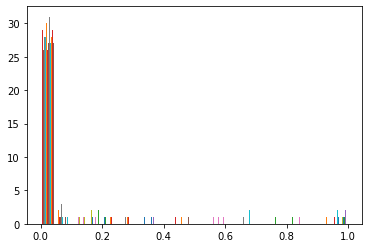

In [36]:
plt.hist(y_out, bins = 20)

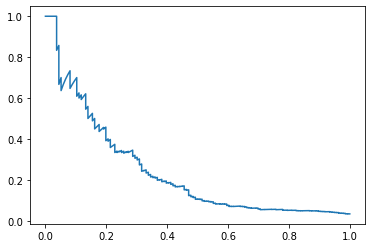

In [37]:
bprc = BinaryPrecisionRecallCurve(thresholds=None)
prec, rec, thres = bprc(torch.squeeze(all_outputs), all_labels)
plt.plot(rec, prec)